# __Detección de TDAH mediante CNN a partir de rs-fMRI__

## __Cargar datos__

Se cargan las señales BOLD extraidas de los $177$ sujetos de la zona NYU

In [29]:
import pandas as pd
import numpy as np

def load_ts_from_csv(path, R=18, T=172):
    df = pd.read_csv(path)
    labels = df["label"].astype(int).tolist()
    ts_data = df.drop(columns=["label"]).values  # (N, R*T)
    ts_list = [row.reshape(R, T) for row in ts_data]
    return ts_list, labels

train_ts_list, train_labels = load_ts_from_csv("https://raw.githubusercontent.com/jpospinalo/TDHA-fMRI/refs/heads/main/data/train_timeseries.csv")
val_ts_list, val_labels     = load_ts_from_csv("https://raw.githubusercontent.com/jpospinalo/TDHA-fMRI/refs/heads/main/data/val_timeseries.csv")

print("Training samples:", len(train_ts_list), "TDAH: ", sum(train_labels))
print("Validation samples:", len(val_ts_list), "TDAH: ", sum(val_labels))

Training samples: 141 TDAH:  72
Validation samples: 36 TDAH:  18


# __Preparación de los datos__

Cada sujeto está representado por una matriz de tamaño **(18, 172)**, donde **18** es el número de ROIs y **172** es la longitud de la señal temporal. Esta matriz se divide en varias ventanas solapadas para capturar la dinámica temporal de la conectividad funcional. El tamaño de cada ventana está dado por la variable `win_len` (establecido en 40), y el desplazamiento entre ventanas stride por la variable `step` (establecido en 15). Al aplicar este proceso, para cada sujeto se generan $W$ ventanas, formando un tensor de tamaño (W, 18, win_len), donde $W$ es el número de ventanas generadas. Posteriormente, el stack de matrices de conectividad funcional dinámica de cada individuo se resume en 5 canales estadísticos de la siguiente forma:

- **Canal 0: Promedio temporal de $z$**  
  `fcs.mean(0)`  
  Calcula el valor promedio de la conectividad (Fisher-z) para cada par de regiones a lo largo de todas las ventanas temporales.

- **Canal 1: Promedio temporal de $|z|$**  
  `abs_z.mean(0)`  
  Calcula el promedio del valor absoluto de la conectividad (Fisher-z) para cada par de regiones.

- **Canal 2: Densidad de conexiones fuertes ($|z| > 0.5$)**  
  `(abs_z > 0.5).mean(0)`  
  Calcula la proporción de ventanas en las que la fuerza de conectividad es moderada a fuerte ($|z| > 0.5$) para cada par de regiones.

- **Canal 3: Densidad de conexiones muy fuertes ($|z| > 0.7$)**  
  `(abs_z > 0.7).mean(0)`  
  Calcula la proporción de ventanas en las que la conectividad es muy fuerte ($|z| > 0.7$) para cada par de regiones.

- **Canal 4: Varianza temporal**  
  `fcs.var(0)`  
  Calcula la varianza de la conectividad (Fisher-z) para cada par de regiones a lo largo del tiempo.


In [20]:
import numpy as np, torch
from torch.utils.data import Dataset

class BoldFcDynamic(Dataset):
    """
    Devuelve:
        bold_tensor : (18, 172)         — señal BOLD normalizada
        fc_tensor   : (5,  18, 18)      — canales dFC mejorados
        label       : int
    """
    def __init__(self, bold_list, labels,
                 win_len=30, step=15, augment=False):
        self.bold   = bold_list
        self.labels = labels
        self.win    = win_len
        self.step   = step
        self.aug    = augment

    def __len__(self): return len(self.bold)

    # ---------- helpers ----------
    def _windows(self, ts):
        starts = range(0, ts.shape[1] - self.win + 1, self.step)
        return np.stack([ts[:, s:s+self.win] for s in starts])  # (W,18,win)

    def _preprocess(self, ts):
        ts = ts - ts.mean(1, keepdims=True)
        ts = ts / (ts.std(1, keepdims=True) + 1e-8)
        return ts.astype(np.float32)

    # ---------- core ----------
    def __getitem__(self, i):
        # -------- BOLD normalizado --------
        ts = self._preprocess(self.bold[i].copy())            # (18,172)

        # -------- augmentación BOLD -------
        if self.aug:
            if np.random.rand() < 0.5:
                ts += np.random.normal(0, 0.05, ts.shape)     # ruido
            if np.random.rand() < 0.3:                        # shift temporal
                shift = np.random.randint(-2, 3)
                if shift > 0:
                    ts = np.pad(ts, ((0,0),(shift,0)), mode='constant')[:, :-shift]
                elif shift < 0:
                    ts = np.pad(ts, ((0,0),(0,-shift)), mode='constant')[:, -shift:]

        # -------- ventanas y dFC ----------
        wins = self._windows(ts)
        assert wins.shape[0] > 0, f"sujeto {i} tiene 0 ventanas"

        fcs = []
        for w in wins:
            r = np.corrcoef(w)
            np.fill_diagonal(r, 0.0)                          # diag = 0
            z = np.arctanh(np.clip(r, -0.999, 0.999))
            fcs.append(z.astype(np.float32))
        fcs = np.stack(fcs)                                   # (W,18,18)

        # -------- canales mejorados -------
        abs_z = np.abs(fcs)
        chan0 =  fcs.mean(0, keepdims=True)                   # media(z)
        chan1 =  abs_z.mean(0, keepdims=True)                 # media(|z|)
        chan2 = (abs_z > 0.5).mean(0, keepdims=True)          # densidad |z|>0.5
        chan3 = (abs_z > 0.7).mean(0, keepdims=True)          # densidad |z|>0.7
        chan4 =  fcs.var(0, keepdims=True)                    # varianza temporal
        fc_tensor = np.concatenate([chan0, chan1, chan2, chan3, chan4], axis=0)  # (5,18,18)

        # -------- normalización global ----
        fc_tensor = (fc_tensor - fc_tensor.mean()) / (fc_tensor.std() + 1e-6)

        # -------- tensores PyTorch --------
        bold_tensor = torch.from_numpy(ts).float()            # (18,172)
        fc_tensor   = torch.from_numpy(fc_tensor).float()     # (5,18,18)
        label       = self.labels[i]

        return fc_tensor, label

## __Definición del modelo__

### __Descripción de la arquitectura__

- **Entrada**:  
  - Tensor de forma `(B, C, 18, 18)`, donde:
    - `B`: tamaño del batch.
    - `C`: número de canales de conectividad funcional (por ejemplo, 5).
    - `18 x 18`: matriz cuadrada de conectividad entre regiones cerebrales (ROIs).

- **Bloques convolucionales principales** (repetidos para cada elemento de `chans`):
  - `nn.Conv2d`:  
    - Núcleos de tamaño `3x3` con padding=1 (mantiene la dimensión espacial).
    - Número de filtros según la secuencia definida en `chans` (por defecto, 32, 64, 128).
  - `nn.GroupNorm`:  
    - Normalización de grupo con 4 grupos, robusta a batch pequeños.
  - `nn.ReLU`:  
    - Activación no lineal.
  - `nn.Dropout2d`:  
    - Regularización con probabilidad `dropout_p` (por defecto, 0.1 o 0.2).
  - `nn.MaxPool2d`:  
    - Pooling máximo con ventana `2x2`, reduce la dimensión espacial a la mitad.

- **Bloque de salida**:
  - `nn.Conv2d`:  
    - Capa de convolución final con `out_chan` filtros (ej: 96, 160, 192 o 256).
  - `nn.GroupNorm` + `nn.ReLU` + `nn.Dropout2d`  
  - `nn.AdaptiveAvgPool2d(1)`:  
    - Pooling adaptativo global, reduce la salida a dimensión `(B, out_chan, 1, 1)`.
  - `nn.Flatten()`:  
    - Aplana a `(B, out_chan)`.
  - `nn.Linear(out_chan, num_classes)`:  
    - Capa totalmente conectada para clasificación binaria o multiclase.



In [21]:
import torch.nn as nn

class FCN2DCNN_GN(nn.Module):
    def __init__(self, in_channels=1, chans=(32, 64, 128),
                 out_chan=256, num_classes=2, dropout_p=0.1):
        super().__init__()
        layers = []
        c_in = in_channels
        for c_out in chans:
            layers += [
                nn.Conv2d(c_in, c_out, 3, padding=1),
                nn.GroupNorm(4, c_out),    # 4 grupos → funciona con batch pequeño
                nn.ReLU(),
                nn.Dropout2d(dropout_p),
                nn.MaxPool2d(2)
            ]
            c_in = c_out

        layers += [
            nn.Conv2d(c_in, out_chan, 3, padding=1),
            nn.GroupNorm(4, out_chan),
            nn.ReLU(),
            nn.Dropout2d(dropout_p),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(out_chan, num_classes)
        ]
        self.net = nn.Sequential(*layers)

    def forward(self, x):                   # x:(B,C,18,18)
        return self.net(x)


## __Entrenamiento del modelo__

Seguarda el modelo con el menor loss en todas las epocas. Early stopping por defecto en 10 épocas

In [22]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import os

def train_and_validate(model, train_loader, val_loader, device,
                       epochs=50, lr=1e-3, weight_decay=1e-4, es_patience=10,
                       checkpoint_path='checkpoints/best_model.pt', verbose=True):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    best_val_acc = 0.0
    best_val_loss = float('inf')
    best_epoch = 0
    epochs_no_improve = 0
    history = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}
    best_val_labels, best_val_preds = None, None

    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_preds, train_labels = 0.0, [], []
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = F.cross_entropy(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = logits.argmax(dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(y.cpu().numpy())
        train_loss /= len(train_loader)
        train_acc = accuracy_score(train_labels, train_preds)

        model.eval()
        val_loss, val_preds, val_labels = 0.0, [], []
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                logits = model(X)
                loss = F.cross_entropy(logits, y)
                val_loss += loss.item()
                preds = logits.argmax(dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(y.cpu().numpy())
        val_loss /= len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds)

        if verbose:
            print(f"Epoch {epoch}/{epochs} — Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f} — Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        scheduler.step(val_loss)

        # --- Guarda el modelo cuando mejora el val_loss ---
        if val_loss < best_val_loss - 1e-4:    # Early stopping y checkpoint por loss
            best_val_loss = val_loss
            best_val_acc  = val_acc
            best_epoch = epoch
            epochs_no_improve = 0
            best_val_labels, best_val_preds = val_labels.copy(), val_preds.copy()
            os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
            torch.save(model.state_dict(), checkpoint_path)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= es_patience:
                if verbose:
                    print(f"--> Early stopping tras {es_patience} épocas sin mejora.")
                break

    if verbose:
        print(f"\nMejor resultado (loss): Epoca {best_epoch}")
        print(f"Validation Loss: {best_val_loss:.4f}")
        print(f"Validation Accuracy: {best_val_acc:.4f}")


    model.load_state_dict(torch.load(checkpoint_path))
    return history, best_val_labels, best_val_preds, model


## __Evaluación simple__

In [23]:
import torch
from torch.utils.data import DataLoader, Dataset


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = FCN2DCNN_GN(
      in_channels=5,
      chans=(32, 64, 128),   # menos filtros
      out_chan=96,          # menos parámetros
      dropout_p=0.2         # más dropout
  ).to(device)


train_ds = BoldFcDynamic(train_ts_list, train_labels, win_len=40, step=15, augment=True)
val_ds = BoldFcDynamic(val_ts_list,   val_labels,   win_len=40, step=15, augment=False)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, drop_last=True)
val_loader = DataLoader(val_ds,   batch_size=len(val_ds), shuffle=False)


history, val_labels, val_preds, _ = train_and_validate(
    model,
    train_loader,
    val_loader,
    device,
    epochs=150,                   # menos épocas para evitar sobreajuste
    lr=1e-4,                      # learning rate más alto
    weight_decay=1e-4,            # más regularización
    es_patience=25
)

Epoch 1/150 — Train Acc: 0.5078, Train Loss: 0.7040 — Val Acc: 0.5000, Val Loss: 0.7155
Epoch 2/150 — Train Acc: 0.3672, Train Loss: 0.7492 — Val Acc: 0.5556, Val Loss: 0.6849
Epoch 3/150 — Train Acc: 0.5391, Train Loss: 0.6950 — Val Acc: 0.5000, Val Loss: 0.6896
Epoch 4/150 — Train Acc: 0.4922, Train Loss: 0.7056 — Val Acc: 0.5278, Val Loss: 0.6840
Epoch 5/150 — Train Acc: 0.4375, Train Loss: 0.7026 — Val Acc: 0.7222, Val Loss: 0.6810
Epoch 6/150 — Train Acc: 0.4375, Train Loss: 0.7145 — Val Acc: 0.5278, Val Loss: 0.6815
Epoch 7/150 — Train Acc: 0.5859, Train Loss: 0.6822 — Val Acc: 0.5000, Val Loss: 0.6863
Epoch 8/150 — Train Acc: 0.4375, Train Loss: 0.7104 — Val Acc: 0.5278, Val Loss: 0.6811
Epoch 9/150 — Train Acc: 0.5312, Train Loss: 0.6931 — Val Acc: 0.6111, Val Loss: 0.6803
Epoch 10/150 — Train Acc: 0.5391, Train Loss: 0.6878 — Val Acc: 0.5000, Val Loss: 0.6833
Epoch 11/150 — Train Acc: 0.5312, Train Loss: 0.6902 — Val Acc: 0.6389, Val Loss: 0.6807
Epoch 12/150 — Train Acc: 0.53

## __Evaluación de estabilidad__

In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def smooth_curve(points, factor=0.8):
    """Media móvil exponencial: suaviza una curva."""
    smoothed = []
    for point in points:
        if smoothed:
            smoothed.append(smoothed[-1] * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

def compute_learning_curves(history, smooth=False, factor=0.8):
    """
    Dibuja curvas de accuracy y loss en entrenamiento/validación.
    Imprime el último valor, el mejor resultado (sin suavizar)
    y los resultados del modelo efectivamente guardado (por mejor val_loss).
    """
    train_acc  = history['train_acc']
    val_acc    = history['val_acc']
    train_loss = history['train_loss']
    val_loss   = history['val_loss']

    # --- Índices de mejores resultados ---
    last_epoch = len(train_acc)
    best_train_acc_idx = np.argmax(train_acc)
    best_val_acc_idx   = np.argmax(val_acc)
    best_train_loss_idx = np.argmin(train_loss)
    best_val_loss_idx   = np.argmin(val_loss)  # <--- este es el modelo guardado (por defecto)

    if smooth:
        train_acc_smooth  = smooth_curve(train_acc, factor)
        val_acc_smooth    = smooth_curve(val_acc, factor)
        train_loss_smooth = smooth_curve(train_loss, factor)
        val_loss_smooth   = smooth_curve(val_loss, factor)
    else:
        train_acc_smooth  = train_acc
        val_acc_smooth    = val_acc
        train_loss_smooth = train_loss
        val_loss_smooth   = val_loss

    epochs = range(1, last_epoch + 1)

    # Subplots 1x2
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy
    axes[0].plot(epochs, train_acc_smooth, label='Training')
    axes[0].plot(epochs, val_acc_smooth, label='Validation')
    axes[0].set_yticks(np.linspace(0.25, 1, 4))
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Accuracy over Epochs')
    axes[0].legend()
    axes[0].grid(True)

    # Loss
    axes[1].plot(epochs, train_loss_smooth, label='Train Loss')
    axes[1].plot(epochs, val_loss_smooth, label='Val Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Loss over Epochs')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    print(f"\n--- Última época ---")
    print(f"Train Accuracy   : {train_acc[-1]:.4f} (Epoch {last_epoch})")
    print(f"Val   Accuracy   : {val_acc[-1]:.4f} (Epoch {last_epoch})")
    print(f"Train Loss       : {train_loss[-1]:.4f} (Epoch {last_epoch})")
    print(f"Val   Loss       : {val_loss[-1]:.4f} (Epoch {last_epoch})")

    print(f"\n--- Modelo guardado (mejor val_loss) ---")
    print(f"Train Accuracy   : {train_acc[best_val_loss_idx]:.4f} (Epoch {best_val_loss_idx+1})")
    print(f"Val   Accuracy   : {val_acc[best_val_loss_idx]:.4f} (Epoch {best_val_loss_idx+1})")
    print(f"Train Loss       : {train_loss[best_val_loss_idx]:.4f} (Epoch {best_val_loss_idx+1})")
    print(f"Val   Loss       : {val_loss[best_val_loss_idx]:.4f} (Epoch {best_val_loss_idx+1})")


def plot_confusion(true_labels, pred_labels, class_names=['TDC', 'ADHD']):
    """
    Dibuja la matriz de confusión.
    """
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()


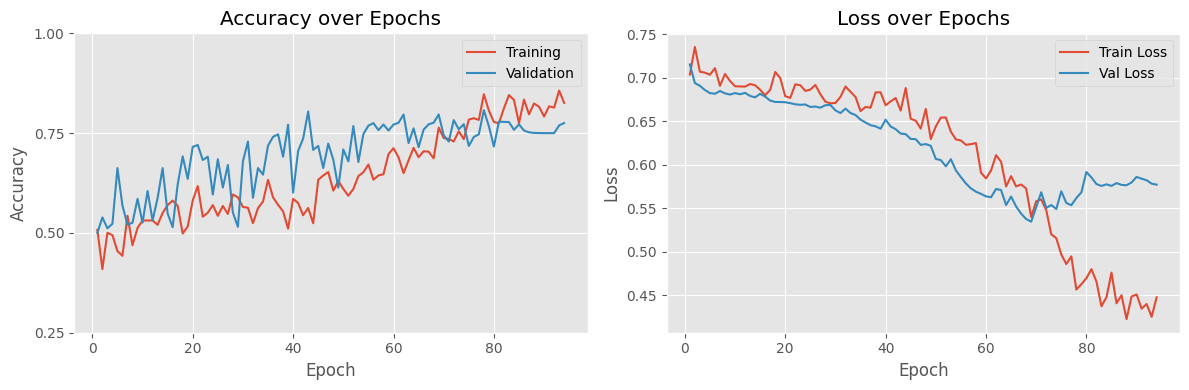


--- Última época ---
Train Accuracy   : 0.8125 (Epoch 94)
Val   Accuracy   : 0.7778 (Epoch 94)
Train Loss       : 0.4573 (Epoch 94)
Val   Loss       : 0.5768 (Epoch 94)

--- Modelo guardado (mejor val_loss) ---
Train Accuracy   : 0.7969 (Epoch 69)
Val   Accuracy   : 0.8056 (Epoch 69)
Train Loss       : 0.5262 (Epoch 69)
Val   Loss       : 0.5333 (Epoch 69)


In [25]:
compute_learning_curves(history, smooth=True, factor=0.3)

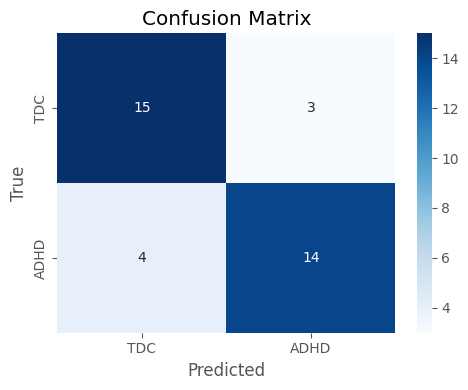

In [26]:
plot_confusion(val_labels, val_preds)

In [28]:
import torch
import numpy as np
import time

N_RUNS = 20   # Número de corridas independientes
accs = []
histories = []

print(f"Ensemble con {N_RUNS} corridas para obtener el accuracy promedio del modelo.")
for run in range(N_RUNS):
    # --- Fija la seed para reproducibilidad (puedes variar para cada run) ---

    seed = int(time.time()) + run
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)

    # --- Vuelve a crear el modelo y optimizador en cada corrida ---
    model = FCN2DCNN_GN(
        in_channels=5,
        chans=(32, 64, 128),
        out_chan=96,
        dropout_p=0.2
    ).to(device)

    train_ds = BoldFcDynamic(train_ts_list, train_labels, win_len=40, step=15, augment=True)
    val_ds   = BoldFcDynamic(val_ts_list,   val_labels,   win_len=40, step=15, augment=False)
    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, drop_last=True)
    val_loader   = DataLoader(val_ds,   batch_size=len(val_ds), shuffle=False)

    history, val_labels, val_preds, _ = train_and_validate(
        model,
        train_loader,
        val_loader,
        device,
        epochs=120,
        lr=1e-4,
        weight_decay=1e-4,
        es_patience=25,
        verbose=False
    )

    # --- Guarda el accuracy del modelo que realmente se guardó (menor val_loss) ---
    best_epoch = np.argmin(history['val_loss'])
    best_acc = history['val_acc'][best_epoch]
    accs.append(best_acc)
    histories.append(history)

    print(f"Run {run+1:02d} | Val Accuracy (modelo guardado): {best_acc:.3f}")

accs = np.array(accs)

print("\n--- Resultados finales ---")
print(f"Número de modelos   : {N_RUNS} ")
print(f"Accuracy promedio   : {accs.mean():.3f}")
print(f"Desviación estándar : {accs.std():.3f}")
print(f"Rango resultados    : {accs.min():.3f} - {accs.max():.3f}")


Ensemble con 20 corridas para obtener el accuracy promedio del modelo.
Run 01 | Val Accuracy (modelo guardado): 0.722
Run 02 | Val Accuracy (modelo guardado): 0.806
Run 03 | Val Accuracy (modelo guardado): 0.722
Run 04 | Val Accuracy (modelo guardado): 0.750
Run 05 | Val Accuracy (modelo guardado): 0.667
Run 06 | Val Accuracy (modelo guardado): 0.583
Run 07 | Val Accuracy (modelo guardado): 0.722
Run 08 | Val Accuracy (modelo guardado): 0.722
Run 09 | Val Accuracy (modelo guardado): 0.833
Run 10 | Val Accuracy (modelo guardado): 0.778
Run 11 | Val Accuracy (modelo guardado): 0.722
Run 12 | Val Accuracy (modelo guardado): 0.583
Run 13 | Val Accuracy (modelo guardado): 0.833
Run 14 | Val Accuracy (modelo guardado): 0.778
Run 15 | Val Accuracy (modelo guardado): 0.694
Run 16 | Val Accuracy (modelo guardado): 0.778
Run 17 | Val Accuracy (modelo guardado): 0.778
Run 18 | Val Accuracy (modelo guardado): 0.806
Run 19 | Val Accuracy (modelo guardado): 0.806
Run 20 | Val Accuracy (modelo guarda